In [57]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

from pathlib import Path
import matplotlib.pyplot as plt

from Data.data_class import plot_electron_spectrogram
from data_loader import MagnetotailDataset
from double_transformer import DoubleTransformer
from double_autoencoder import DoubleAutoencoder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA")

2.2.1
12.1
True
NVIDIA GeForce RTX 4060 Laptop GPU


In [11]:
# TRAINING DATASET
file_path = Path('..') / "Data" / "training_data" / "test.h5"
abs_file_path = file_path.resolve()

# Create dataset
dataset = MagnetotailDataset(abs_file_path)


In [12]:
dataset.get_session_info()

[{'id': 'session_0000',
  'start_time': '2011-08-14 00:00:00',
  'end_time': '2011-08-15 23:59:00',
  'num_timestamps': 280,
  'variables': ['B_electron_avgtemp',
   'B_electron_density',
   'B_electron_eflux',
   'B_electron_velocity_gsm',
   'B_electron_vthermal',
   'B_ion_avgtemp',
   'B_ion_density',
   'B_ion_eflux',
   'B_ion_velocity_gsm',
   'B_ion_vthermal',
   'B_magnetic_field_gsm',
   'times']},
 {'id': 'session_0001',
  'start_time': '2011-11-12 00:00:00',
  'end_time': '2011-11-14 23:59:00',
  'num_timestamps': 406,
  'variables': ['B_electron_avgtemp',
   'B_electron_density',
   'B_electron_eflux',
   'B_electron_velocity_gsm',
   'B_electron_vthermal',
   'B_ion_avgtemp',
   'B_ion_density',
   'B_ion_eflux',
   'B_ion_velocity_gsm',
   'B_ion_vthermal',
   'B_magnetic_field_gsm',
   'times']},
 {'id': 'session_0002',
  'start_time': '2011-08-16 00:00:00',
  'end_time': '2011-08-18 00:00:00',
  'num_timestamps': 314,
  'variables': ['B_electron_avgtemp',
   'B_electro

In [13]:
# TESTING DATASET
file_path = Path('..') / "Data" / "testing_data" / "test1.h5"
abs_file_path = file_path.resolve()

# Create dataset
testing_dataset = MagnetotailDataset(abs_file_path)

In [14]:
# Create a list of cutoff times for training
initial_cutoff_list = ['2011-08-14 22:50:00', 
                       '2011-11-12 05:40:00',
                       '2011-11-13 01:00:00',
                       '2011-11-13 22:00:00',
                       '2011-08-17 08:00:00',
                       '2011-08-16 01:10:00',
                       '2011-09-13 17:00:00',
                       '2011-09-14 13:15:00',
                       '2011-09-14 23:00:00',
                       '2012-02-09 11:00:00',
                       '2012-05-03 23:00:00', 
                       '2012-11-30 10:30:00',
                       ]
final_cutoff_list = ['2011-08-15 18:30:00',
                     '2011-11-12 06:40:00',
                     '2011-11-13 04:30:00',
                     '2011-11-13 23:30:00',
                     '2011-08-17 09:00:00',
                     '2011-08-16 02:30:00',
                     '2011-09-13 21:00:00',
                     '2011-09-14 14:15:00',
                     '2011-09-15 00:30:00',
                     '2012-02-09 14:00:00',
                     '2012-05-04 07:00:00',
                     '2012-11-30 12:00:00',
                     ]


# Assing the trainable times to the dataset
dataset.exclude_time_ranges(initial_cutoffs=initial_cutoff_list,
                           final_cutoffs=final_cutoff_list
                           )
dataset.set_trainable_samples()


{'section_000': {'session_id': ['session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
  

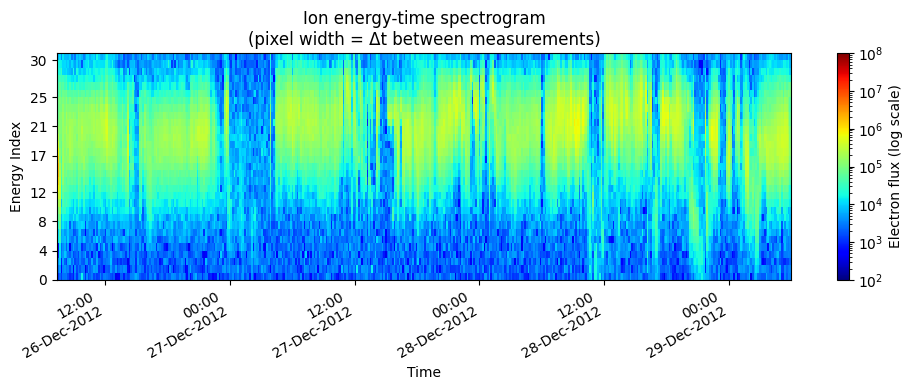

In [17]:
dataset.set_regions_for_sections()

In [19]:
# Get the trainable samples from the dataset
train_samples = dataset.get_trainable_samples()

# Define how many time steps to use for the input
timestamps = 4

# Initialize the autoencoder
MAE_transformer = DoubleTransformer(
    input_dim=31, 
    timestamps=timestamps, 
    d_model=32, 
    nhead=4, 
    num_encoder_layers=4,            
    num_decoder_layers=4, 
    dim_feedforward=192, 
    mask_ratio=0.3,
    patches_per_timestamp=4
    )

autoencoder = DoubleAutoencoder(hidden_layer_1=16, hidden_layer_2=32, hidden_layer_3=32,  latent_dim=32, timestamps=timestamps)

Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4


In [20]:
train_loss_tail, test_loss_tail,train_loss_sheath, test_loss_sheath = MAE_transformer.fit(train_samples, epochs=(20, 80), batch_size=256, learning_rate=0.001)

16-Jun-25 21:38:48: c:\Users\ianma\miniconda3\envs\deep_learning\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)



Epoch [1/20], Loss: 0.5075, Test Loss: 0.4108
Epoch [2/20], Loss: 0.4109, Test Loss: 0.3998
Epoch [3/20], Loss: 0.3971, Test Loss: 0.3874
Epoch [4/20], Loss: 0.3769, Test Loss: 0.3557
Epoch [5/20], Loss: 0.3413, Test Loss: 0.3133
Epoch [6/20], Loss: 0.2831, Test Loss: 0.2374
Epoch [7/20], Loss: 0.2202, Test Loss: 0.1930
Epoch [8/20], Loss: 0.1860, Test Loss: 0.1651
Epoch [9/20], Loss: 0.1609, Test Loss: 0.1441
Epoch [10/20], Loss: 0.1400, Test Loss: 0.1274
Epoch [11/20], Loss: 0.1204, Test Loss: 0.1099
Epoch [12/20], Loss: 0.1080, Test Loss: 0.1043
Epoch [13/20], Loss: 0.1024, Test Loss: 0.0987
Epoch [14/20], Loss: 0.0963, Test Loss: 0.0903
Epoch [15/20], Loss: 0.0898, Test Loss: 0.0893
Epoch [16/20], Loss: 0.0863, Test Loss: 0.0865
Epoch [17/20], Loss: 0.0839, Test Loss: 0.0837
Epoch [18/20], Loss: 0.0814, Test Loss: 0.0795
Epoch [19/20], Loss: 0.0793, Test Loss: 0.0783
Epoch [20/20], Loss: 0.0777, Test Loss: 0.0785
Epoch [1/80], Loss: 2.5000, Test Loss: 2.2967
Epoch [2/80], Loss: 2.2

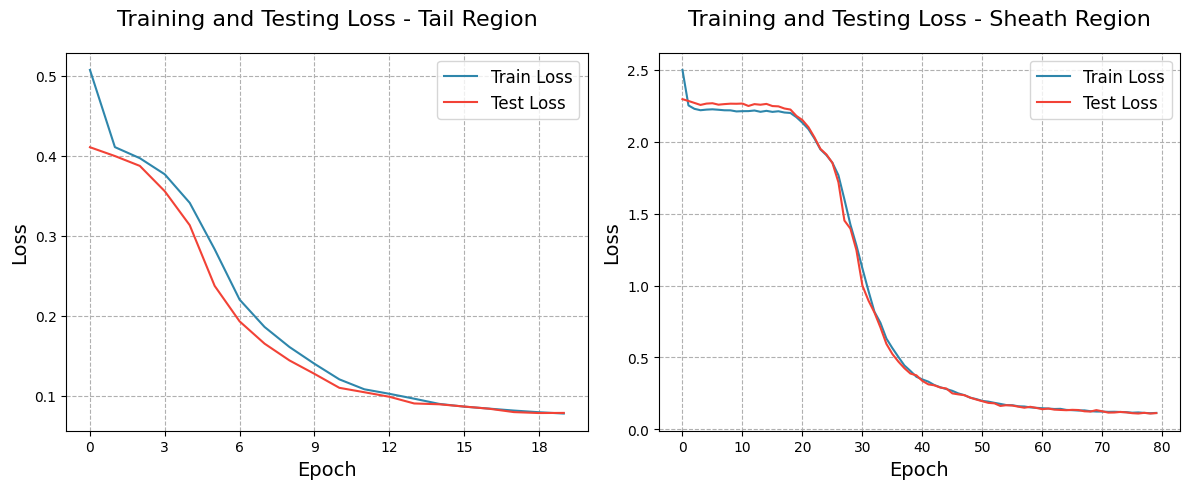

In [21]:
# Plotting the training and testing loss for the tail and sheath regions

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(train_loss_tail, label='Train Loss', color='#2E86AB')
axs[0].plot(test_loss_tail, label='Test Loss', color='#F24236')
axs[0].set_xlabel('Epoch', fontsize=14)
axs[0].set_ylabel('Loss', fontsize=14)
axs[0].set_title('Training and Testing Loss - Tail Region', fontsize=16, pad=20)
axs[0].legend(fontsize=12)
axs[0].grid(True, alpha=1, linestyle='--')
axs[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

axs[1].plot(train_loss_sheath, label='Train Loss', color='#2E86AB')
axs[1].plot(test_loss_sheath, label='Test Loss', color='#F24236')
axs[1].set_xlabel('Epoch', fontsize=14)
axs[1].set_ylabel('Loss', fontsize=14)
axs[1].set_title('Training and Testing Loss - Sheath Region', fontsize=16, pad=20)
axs[1].legend(fontsize=12)
axs[1].grid(True, alpha=1, linestyle='--')
axs[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

In [22]:
test_samples = testing_dataset.get_trainable_samples()

In [24]:
results_tail_model, results_sheath_model, prepared_data = MAE_transformer.predict(test_samples)

In [31]:
n_sample = 65

test_sample_example = prepared_data[n_sample, :, :].cpu().numpy()
result_tail_model_example = results_tail_model[n_sample, :, :].cpu().numpy()
result_sheath_model_example = results_sheath_model[n_sample, :, :].cpu().numpy()

16-Jun-25 21:39:56: C:\Users\ianma\AppData\Local\Temp\ipykernel_7332\647492426.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks[::-1])

16-Jun-25 21:39:56: C:\Users\ianma\AppData\Local\Temp\ipykernel_7332\647492426.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks[::-1])

16-Jun-25 21:39:56: C:\Users\ianma\AppData\Local\Temp\ipykernel_7332\647492426.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks[::-1])



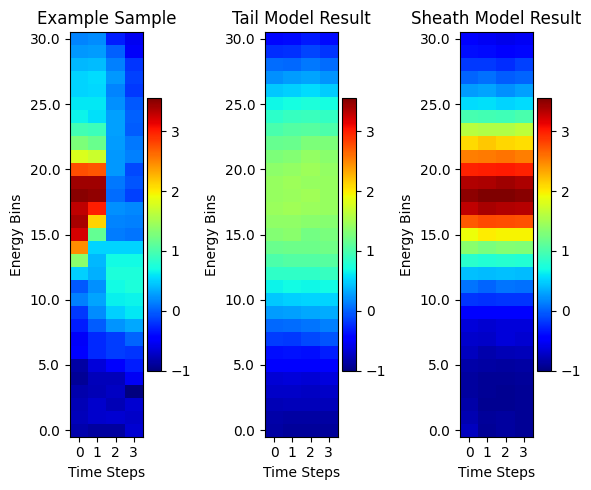

In [32]:
import matplotlib.ticker as ticker

fig, axs = plt.subplots(1, 3, figsize=(6, 5))

# Find global min and max across all data
vmin = min(test_sample_example.min(), result_tail_model_example.min(), result_sheath_model_example.min())
vmax = max(test_sample_example.max(), result_tail_model_example.max(), result_sheath_model_example.max())

def invert_yaxis_ticks(ax):
    yticks = ax.get_yticks()
    ax.set_yticklabels(yticks[::-1])

# Plot test sample example
im1 = axs[0].imshow(test_sample_example.T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax)
axs[0].set_title('Example Sample')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Energy Bins')
axs[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
axs[0].yaxis.set_major_locator(ticker.MultipleLocator(5))
axs[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%i'))

plt.colorbar(im1, ax=axs[0])
invert_yaxis_ticks(axs[0])

# Plot tail model result
im2 = axs[1].imshow(result_tail_model_example.T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax)
axs[1].set_title('Tail Model Result')
axs[1].set_xlabel('Time Steps')
axs[1].set_ylabel('Energy Bins')
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(1))
axs[1].yaxis.set_major_locator(ticker.MultipleLocator(5))
axs[1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%i'))

plt.colorbar(im2, ax=axs[1])
invert_yaxis_ticks(axs[1])

# Plot sheath model result
im3 = axs[2].imshow(result_sheath_model_example.T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax)
axs[2].set_title('Sheath Model Result')
axs[2].set_xlabel('Time Steps')
axs[2].set_ylabel('Energy Bins')
axs[2].xaxis.set_major_locator(ticker.MultipleLocator(1))
axs[2].yaxis.set_major_locator(ticker.MultipleLocator(5))
axs[2].yaxis.set_major_formatter(ticker.FormatStrFormatter('%i'))

plt.colorbar(im3, ax=axs[2])
invert_yaxis_ticks(axs[2])

plt.tight_layout()
plt.show()


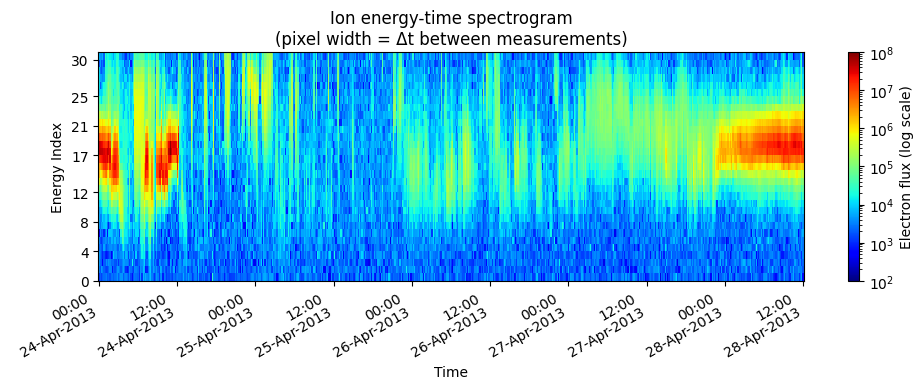

Invalid input. Please enter '1' for magnetotail or '2' for magnetosheath.
Due to invalid input, region was set to None


In [ ]:
testing_dataset.set_regions_for_sections()

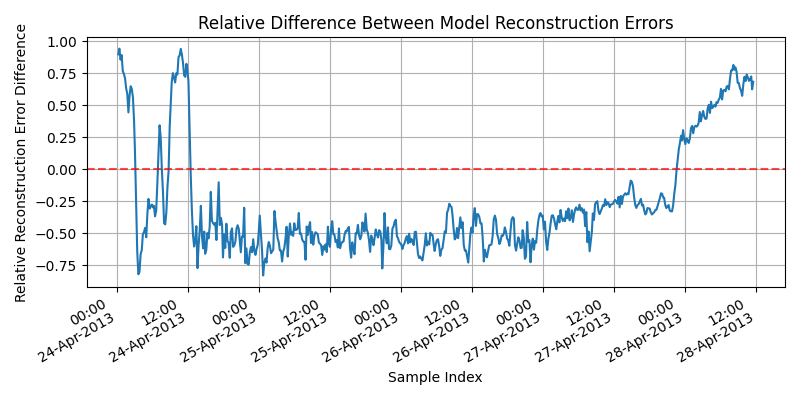

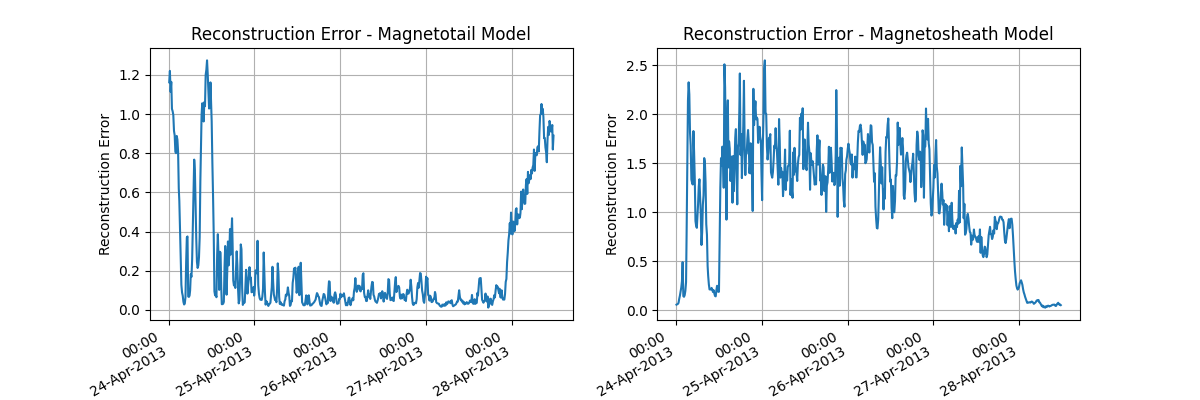

In [61]:
%matplotlib widget
_ = MAE_transformer.plot_results(test_samples, times=test_samples['section_000']['times'], figsize=(12, 4))

In [ ]:
section_to_region_map = dataset.get_section_to_region_map()

In [ ]:
import datetime

for key in train_samples.keys():

    # Get the time data from train_samples
    sample_times = train_samples[key]['times']

    # Get the first time (nanoseconds since 1970)
    first_time_ns = sample_times[0].item()  # Convert tensor to Python number

    # Convert nanoseconds to seconds
    first_time_s = first_time_ns / 1e9

    # Convert to datetime
    first_time_datetime = datetime.datetime.fromtimestamp(first_time_s)

    print(f"First timestamp: {first_time_datetime}")


First timestamp: 2011-08-14 02:00:52.837745
First timestamp: 2011-08-15 20:39:32.148773
First timestamp: 2011-11-12 00:58:56.508330
First timestamp: 2011-11-12 07:44:23.203094
First timestamp: 2011-11-13 05:36:55.723434
First timestamp: 2011-11-14 00:35:22.883310
First timestamp: 2011-08-16 02:00:13.602259
First timestamp: 2011-08-16 04:35:59.451095
First timestamp: 2011-08-17 11:03:55.735966
First timestamp: 2011-11-09 01:01:04.081035
First timestamp: 2011-09-13 23:09:15.241497
First timestamp: 2011-09-14 16:22:20.209512
First timestamp: 2011-09-15 02:33:56.410089
First timestamp: 2012-02-08 00:59:56.853354
First timestamp: 2012-02-09 15:06:00.928920
First timestamp: 2012-05-02 01:59:58.230397
First timestamp: 2012-05-04 09:05:22.640257
First timestamp: 2012-11-27 01:08:22.327083
First timestamp: 2012-11-30 03:00:46.702051
First timestamp: 2012-11-30 13:05:30.585768
First timestamp: 2011-12-08 05:00:07.292944
First timestamp: 2011-12-10 09:29:45.853968
First timestamp: 2012-01-07 04:2

In [ ]:
test_samples['section_000']['B_ion_eflux'].shape

torch.Size([574, 31])

In [ ]:
import torch.nn.functional as F

# Apply window averaging with padding
# Input shape: [timesteps, energybins]
B_ion_eflux = test_samples['section_000']['B_ion_eflux']

# Add batch and channel dimensions for conv1d: [batch, channels, timesteps]
B_ion_eflux_expanded = B_ion_eflux.transpose(0, 1).unsqueeze(0)  # [1, energybins, timesteps]

# Create averaging kernel of size 5
kernel = torch.ones(1, 1, 3) / 3.0  # [out_channels, in_channels, kernel_size]

# Apply 1D convolution with padding=2 to maintain original length
B_ion_eflux_smoothed = F.conv1d(B_ion_eflux_expanded, kernel.expand(B_ion_eflux_expanded.size(1), 1, -1), 
                                padding=1, groups=B_ion_eflux_expanded.size(1))

# Reshape back to original format: [timesteps, energybins]
B_ion_eflux_smoothed = B_ion_eflux_smoothed.squeeze(0).transpose(0, 1)

print(f"Original shape: {B_ion_eflux.shape}")
print(f"Smoothed shape: {B_ion_eflux_smoothed.shape}")

Original shape: torch.Size([574, 31])
Smoothed shape: torch.Size([574, 31])


In [ ]:
B_ion_eflux_smoothed.shape

torch.Size([574, 31])

In [ ]:
B_ion_eflux_smoothed.max(dim=1).values

tensor([2.8203e+07, 4.2978e+07, 4.4461e+07, 4.0188e+07, 3.4512e+07, 2.9119e+07,
        3.3388e+07, 3.6418e+07, 3.6895e+07, 2.1979e+07, 1.4209e+07, 1.2615e+07,
        2.0085e+07, 2.1175e+07, 1.7127e+07, 1.0682e+07, 5.6941e+06, 2.6014e+06,
        4.9118e+05, 2.9509e+05, 1.6049e+05, 6.2198e+04, 3.5504e+04, 2.4211e+04,
        3.8261e+04, 3.2890e+04, 3.2749e+04, 3.1485e+04, 2.6843e+05, 4.5735e+05,
        6.7076e+05, 6.3769e+05, 6.7766e+05, 6.7025e+05, 6.6301e+05, 6.0933e+05,
        1.3071e+06, 8.9965e+06, 1.7103e+07, 1.8456e+07, 1.2680e+07, 2.4172e+06,
        1.9095e+06, 1.7446e+06, 1.4637e+06, 1.2379e+05, 3.0459e+06, 6.7355e+06,
        1.6580e+07, 2.3192e+07, 2.2780e+07, 1.9986e+07, 1.5960e+07, 1.9241e+07,
        1.9324e+07, 2.2417e+07, 1.9268e+07, 5.4485e+07, 6.6676e+07, 5.8144e+07,
        3.0937e+07, 3.1142e+07, 2.9256e+07, 2.3889e+07, 2.0555e+07, 1.2313e+07,
        1.1420e+07, 5.7221e+04, 5.7844e+04, 4.7111e+04, 2.7307e+04, 1.4632e+04,
        8.9172e+03, 7.8218e+03, 2.1018e+

In [ ]:
avg_test_samples = torch.log(B_ion_eflux_smoothed).mean(dim=1)
std_test_samples = torch.log(B_ion_eflux_smoothed).std(dim=1)

avg_test_samples_norm = (avg_test_samples) / (avg_test_samples.max() - avg_test_samples.min())
std_test_samples_norm = (std_test_samples) / (torch.log(B_ion_eflux_smoothed).max(dim=1).values - torch.log(B_ion_eflux_smoothed).min(dim=1).values)

In [ ]:
opp_avg_test_samples = 1/avg_test_samples_norm 
opp_avg_test_samples_norm = (opp_avg_test_samples) / (opp_avg_test_samples.max() - opp_avg_test_samples.min())

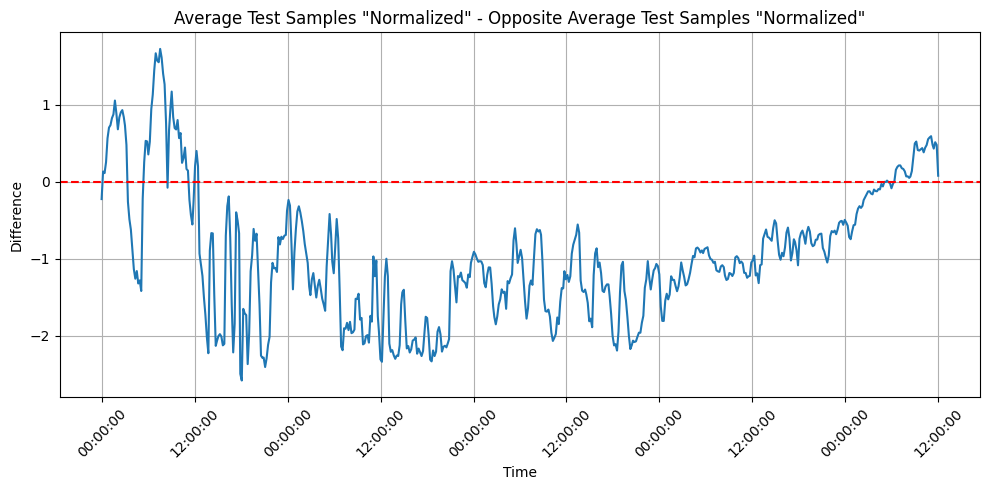

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime, timezone
from matplotlib import dates as mdates
import numpy as np

time_ns = test_samples['section_000']['times'].cpu().numpy().astype('int64')
time_s = time_ns / 1e9
times_datetime = [datetime.fromtimestamp(ts, timezone.utc) for ts in time_s]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(times_datetime,avg_test_samples.numpy() - 2*std_test_samples_norm.numpy() - 10, label='Average Test Samples Normalized')    
ax.set_title('Average Test Samples "Normalized" - Opposite Average Test Samples "Normalized"')
ax.set_xlabel('Time')
ax.set_ylabel("Difference")
ax.axhline(0, color='red', linestyle='--', label='Zero Line')
ax.grid()
ax.xaxis_date()
# Format the x-axis to display times nicely
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
 

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

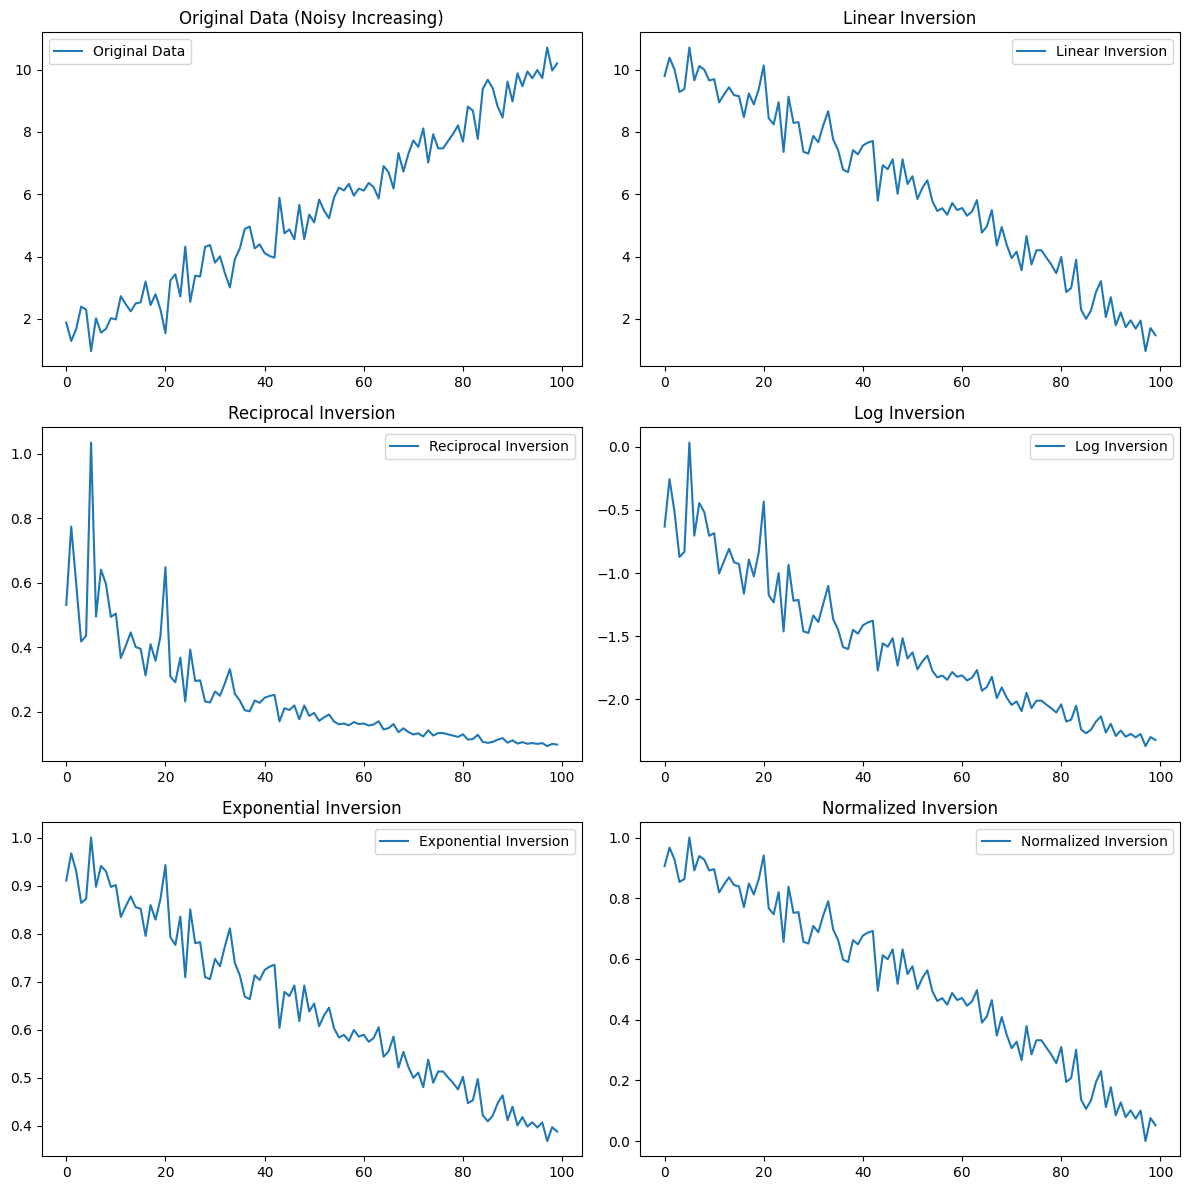

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate noisy increasing data
np.random.seed(0)
x = np.linspace(1, 10, 100) + np.random.normal(0, 0.5, 100)  # avoid zero for log/reciprocal
x = np.clip(x, 1e-3, None)  # Ensure all values are > 0

# Define transformation functions
def linear_inversion(x):
    return np.max(x) + np.min(x) - x

def reciprocal_inversion(x):
    return 1.0 / (x + 1e-5)

def log_inversion(x):
    return -np.log(x + 1e-5)

def exp_inversion(x):
    x_norm = (x - np.min(x)) / (np.max(x) - np.min(x))
    return np.exp(-x_norm)

def normalized_inversion(x):
    return (np.max(x) - x) / (np.max(x) - np.min(x))

# Apply transformations
y_linear = linear_inversion(x)
y_recip = reciprocal_inversion(x)
y_log = log_inversion(x)
y_exp = exp_inversion(x)
y_norm = normalized_inversion(x)

# Plotting
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs = axs.ravel()

axs[0].plot(x, label='Original Data')
axs[0].set_title('Original Data (Noisy Increasing)')
axs[0].legend()

axs[1].plot(y_linear, label='Linear Inversion')
axs[1].set_title('Linear Inversion')
axs[1].legend()

axs[2].plot(y_recip, label='Reciprocal Inversion')
axs[2].set_title('Reciprocal Inversion')
axs[2].legend()

axs[3].plot(y_log, label='Log Inversion')
axs[3].set_title('Log Inversion')
axs[3].legend()

axs[4].plot(y_exp, label='Exponential Inversion')
axs[4].set_title('Exponential Inversion')
axs[4].legend()

axs[5].plot(y_norm, label='Normalized Inversion')
axs[5].set_title('Normalized Inversion')
axs[5].legend()

plt.tight_layout()
plt.show()